## Loading Clawpack Data with yt

This notebook demonstrates how yt can be used to read, visualize, and analyze Clawpack simulation data. Since yt does not currently support Clawpack directly, we load the data via the generic `load_amr_grids` method.

In [285]:
import yt
import numpy as np
from clawpack.pyclaw.solution import Solution

The following is based on https://github.com/clawpack/yt_tests/blob/master/burgers_3d_cubedata/yt_plots.ipynb


In [286]:
def load_ds(frame,path='./output'):
    """
    Load a frame of data and reformat for yt.
    """
    sol = Solution(frame,path=path,file_format='ascii',file_prefix='fort')

    grid_data = []

    for state in sorted(sol.states, key = lambda a: a.patch.level):
        patch = state.patch

        # yt expects 3d data
        left_edge = patch.lower_global + [0]
        right_edge = patch.upper_global + [1]
        dimensions = patch.num_cells_global + [1]
        
        d = {
            'left_edge': left_edge,
            'right_edge': right_edge,
            'level': patch.level - 1,  # AMR level - 1
            'dimensions': dimensions,
            'depth': (state.q[0,...,np.newaxis], "m"), # Add 3rd dimension
            'velocity': (state.q[1,...,np.newaxis], "m/s"), # Add 3rd dimension
            }
        grid_data.append(d)
                
    domain = [200, 28, 1]   
    bbox = np.array([[-10,140], [-6,8], [0,1]])
    return yt.load_amr_grids(grid_data, domain, bbox = bbox, refine_by=5, parameters = {})

Load the data from one frame/timestep into yt. The underling 

In [287]:
ds = load_ds(4)
ds

StreamDataset: AMRGridData

Inspect the field list

In [288]:
ds.field_list

[('stream', 'depth'), ('stream', 'velocity')]

Inspect the maximum refinement level. Recall that this is (AMR level - 1)

In [289]:
ds.max_level

1


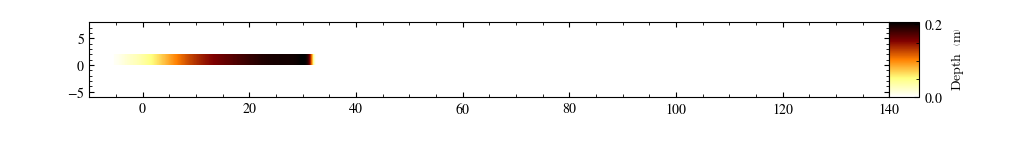

In [290]:
field=("stream", "depth")
p = yt.SlicePlot(ds, "z", field, origin="native", fontsize=10)
p.set_cmap(field=field, cmap="afmhot_r")
p.set_log(field, False)
p.set_xlabel("")
p.set_ylabel("")
p.show()

From here we can find the field maximum, [select or filter data](https://yt-project.org/doc/analyzing/objects.html)

In [193]:
ds.find_max("depth")

(unyt_quantity(0.20608137, 'm'),
 unyt_array([30.125,  1.65 ,  0.5  ], 'code_length'))

In [283]:
ds.point([20,1,0])[field]

unyt_array([0.18438657], 'm')


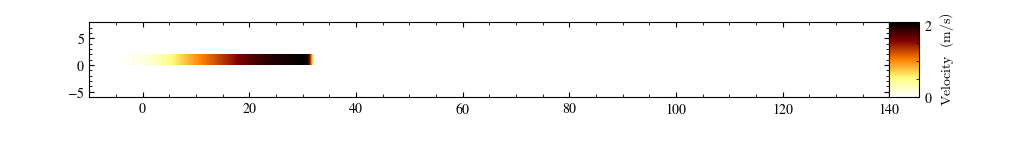

In [257]:
field=("stream", "velocity")
p = yt.SlicePlot(ds, "z", field, origin="native", fontsize=10)
p.set_cmap(field=field, cmap="afmhot_r")
p.set_log(field, False)
p.set_xlabel("")
p.set_ylabel("")
p.show()

In [284]:
ds.find_max("velocity")

(unyt_quantity(2.08697355, 'm/s'),
 unyt_array([30.125,  1.95 ,  0.5  ], 'code_length'))

## Where can we go from here?

This example uses [load_amr_grids](https://yt-project.org/doc/examining/loading_data.html?highlight=load_amr_grid#generic-amr-data) to load generic AMR data into memory. yt is designed to support more efficient data access by [loading data via functions](https://yt-project.org/doc/examining/loading_via_functions.html#loading-via-functions) or through the development of a custom [frontend](https://yt-project.org/doc/developing/creating_frontend.html). Among other things, this would enable use of yt's [time series analysis](https://yt-project.org/doc/analyzing/time_series_analysis.html#time-series-analysis) capabilities to analyze the entire simulation.

Some ideas:
* Write a custom function to load data when accessed: as above, but more efficiently access AMR data via lazy-loading
* Create [DatasetSeries](https://yt-project.org/doc/reference/api/yt.data_objects.time_series.html#yt.data_objects.time_series.DatasetSeries) based on the existing stream frontend to enable analysis of multiple frames/timesteps.
* Write a new [frontend](https://yt-project.org/doc/developing/creating_frontend.html) for Clawpack
